# 단순 절대 모멘텀
- 투자 기간 : 1986년 1월~2017년 6월
- 투자 대상 : 코스피지수
- 매수 규칙 : 당월 추가 > n 개월 전 주가(n개월 모멘텀 > 0) → 주식 매수
- 매도 규칙 : 당월 주가 < n 개월 전 주가(개월 모멘텀 < 0) → 주식 매도, 현금 보유
- 문제점
  1. 1~12개월 모멘텀이 모두 잘 작동하는데 대체 어느 모멘텀을 기준으로 투자해야 하는지 모릅니다.
  2. 변동성이 크게 줄긴 했어도 사람에 따라 이 정도의 손실도 크다고 생각할 수도 있고, 시장 상황에 따라 우월하게 나타나는 모멘텀 기간 값이 그때마다 다릅니다.
  3. 모멘텀 전략이 급락장에서의 손실을 크게 줄일 수 있다는 장점이 있지만, 추세추종 매매의 본질상 오히려 횡보 구간에서는 손실이 커집니다.
- 해결법
  - 1, 2번 문제는 평균 모멘텀 스코어 도입
  - 3번(횡보 구간) 문제
      1. 주식과 상관성이 낮은 자산을 분산해서 혼합 : 현금과 채권(동일한 자산군으로 취급하여 모멘텀 비중도 동일하게 계산하여 투자 비중 결정)
      2. 전략 수익곡선에 평균 모멘텀 스코어 전략 적용('**수익곡선 모멘텀 전략**')

In [1]:
from settings import *

In [2]:
kospi = fdr.DataReader("KS11")[['Close']] # dataframe [['Close]]
kospi.columns = ['KOSPI']
kospi.info() # 1981-05-01 to 2022-01-19

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10875 entries, 1981-05-01 to 2022-01-21
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   KOSPI   10875 non-null  float64
dtypes: float64(1)
memory usage: 169.9 KB


In [3]:
data = kospi['1986-1':'2017-6'].copy()
data_m = data.resample('MS').first() # 월초
data_m.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 378 entries, 1986-01-01 to 2017-06-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   KOSPI   378 non-null    float64
dtypes: float64(1)
memory usage: 5.9 KB


In [4]:
data_m

,KOSPI
Date,
1986-01-01,161.400
1986-02-01,162.450
1986-03-01,179.330
1986-04-01,200.150
1986-05-01,202.880
...,...
2017-02-01,2080.480
2017-03-01,2102.650
2017-04-01,2167.510


In [5]:
def momentum(data, trend, name='1개월모멘텀'):
    s = bt.Strategy(
        name,
        [
            bt.algos.RunMonthly(run_on_first_date=True, run_on_last_date=True),
            bt.algos.SelectWhere(trend), # !!!
            bt.algos.WeighEqually(),
            bt.algos.PrintInfo("{now} {temp}"),
            bt.algos.Rebalance()
        ])
    test = bt.Backtest(s, data, initial_capital=100000000)

    return test

In [6]:
bt_kospi = long_only_ew(data_m, ["KOSPI"], "KOSPI", initial_capital=100000000)

## 비중 데이터프레임을 별도로 만들어서 일반화 함 (SelectWhere(weights))

In [7]:
# 절대 모멘텀은 이동평균이 아니라 단순히 과거 시점 대비 현재를 비교한다.
# 1개월 모멘텀 (data는 월간 데이터)
prev = data_m.shift(1)
trend = prev.copy()
trend[data_m > prev] = True
trend[data_m <= prev] = False
trend[prev.isnull()] = False
trend.tail()

,KOSPI
Date,
2017-02-01,True
2017-03-01,True
2017-04-01,True
2017-05-01,True
2017-06-01,True


In [8]:
bt_1m = momentum(data_m, trend, "1개월모멘텀")
rm_kospi = bt.run(bt_kospi)
rm1 = bt.run(bt_1m)
rm1_assets = bt.run(bt_kospi, bt_1m)

1986-01-01 00:00:00
1986-01-01 00:00:00 {'selected': [], 'weights': {}}
1986-02-01 00:00:00 {'selected': ['KOSPI'], 'weights': {'KOSPI': 1.0}}
1986-03-01 00:00:00 {'selected': ['KOSPI'], 'weights': {'KOSPI': 1.0}}
1986-04-01 00:00:00 {'selected': ['KOSPI'], 'weights': {'KOSPI': 1.0}}
1986-05-01 00:00:00 {'selected': ['KOSPI'], 'weights': {'KOSPI': 1.0}}
1986-06-01 00:00:00 {'selected': ['KOSPI'], 'weights': {'KOSPI': 1.0}}
1986-07-01 00:00:00 {'selected': ['KOSPI'], 'weights': {'KOSPI': 1.0}}
1986-08-01 00:00:00 {'selected': ['KOSPI'], 'weights': {'KOSPI': 1.0}}
1986-09-01 00:00:00 {'selected': [], 'weights': {}}
1986-10-01 00:00:00 {'selected': [], 'weights': {}}
1986-11-01 00:00:00 {'selected': [], 'weights': {}}
1986-12-01 00:00:00 {'selected': ['KOSPI'], 'weights': {'KOSPI': 1.0}}
1987-01-01 00:00:00 {'selected': [], 'weights': {}}
1987-02-01 00:00:00 {'selected': ['KOSPI'], 'weights': {'KOSPI': 1.0}}
1987-03-01 00:00:00 {'selected': ['KOSPI'], 'weights': {'KOSPI': 1.0}}
1987-04-01

In [9]:
rm1_assets.display()

Stat                 KOSPI       1개월모멘텀
-------------------  ----------  -------------
Start                1985-12-31  1985-12-31
End                  2017-06-01  2017-06-01
Risk-free rate       0.00%       0.00%

Total Return         1352.67%    1570.26%
Daily Sharpe         2.03        2.63
Daily Sortino        4.10        5.05
CAGR                 8.89%       9.38%
Max Drawdown         -72.43%     -30.90%
Calmar Ratio         0.12        0.30

MTD                  5.63%       5.63%
3m                   11.51%      11.51%
6m                   18.19%      15.72%
YTD                  18.19%      15.72%
1Y                   18.25%      17.16%
3Y (ann.)            5.41%       9.06%
5Y (ann.)            5.03%       5.53%
10Y (ann.)           3.17%       3.17%
Since Incep. (ann.)  8.89%       9.38%

Daily Sharpe         2.03        2.63
Daily Sortino        4.10        5.05
Daily Mean (ann.)    254.95%     223.28%
Daily Vol (ann.)     125.45%     84.86%
Daily Skew           0.71        0.

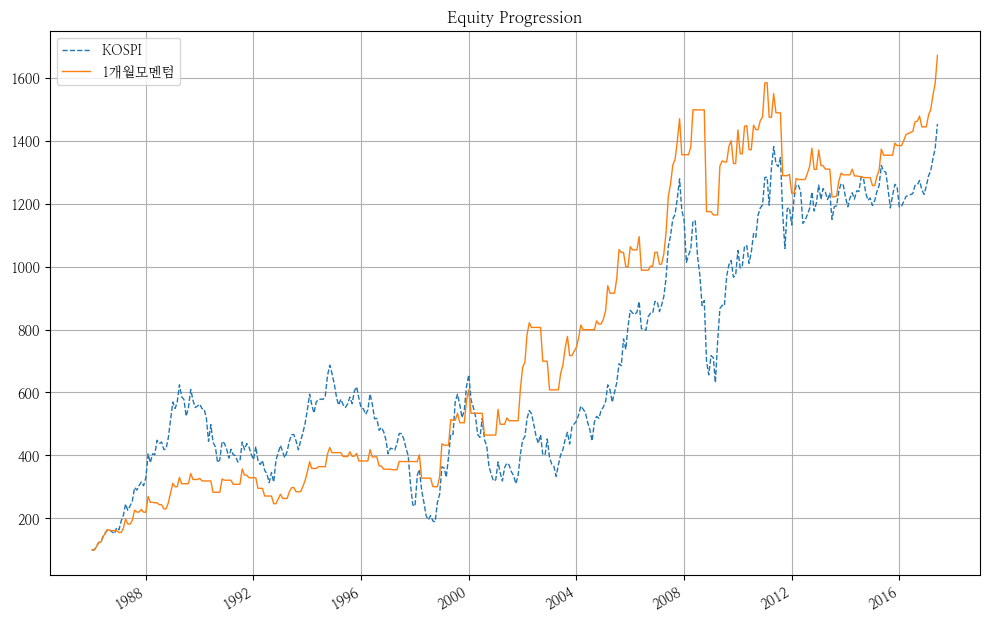

In [10]:
ax1 = rm_kospi.plot(ls='--', figsize=(12, 8));
rm1.plot(ax=ax1, figsize=(12,8));

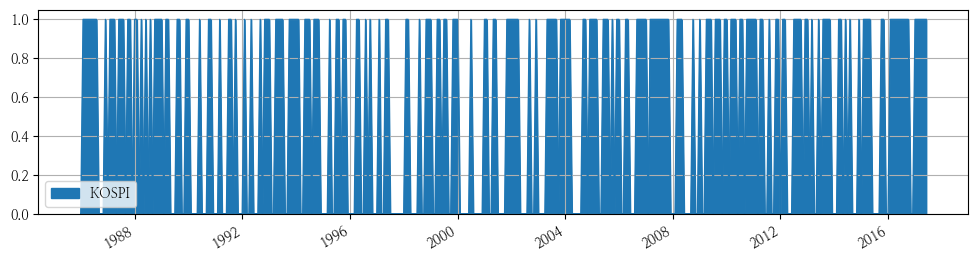

In [12]:
rm1.get_security_weights().plot.area(figsize=(12,3));

In [14]:
rm1.get_transactions().head(10)

,,price,quantity
Date,Security,,
1986-02-01,KOSPI,162.450,615574.000
1986-09-01,KOSPI,262.340,-615574.000
1986-12-01,KOSPI,275.150,586915.000
1987-01-01,KOSPI,264.820,-586915.000
1987-02-01,KOSPI,310.830,500038.000
1987-05-01,KOSPI,364.550,-500038.000
1987-06-01,KOSPI,387.440,470495.000
1987-09-01,KOSPI,468.380,-470495.000
1987-10-01,KOSPI,491.600,448272.000


In [17]:
# 거래 발생
rm1.backtest_list[0].positions.diff(1).head(10)

,KOSPI
1985-12-31,NaN
1986-01-01,0.000
1986-02-01,615574.000
1986-03-01,0.000
1986-04-01,0.000
1986-05-01,0.000
1986-06-01,0.000
1986-07-01,0.000
1986-08-01,0.000
1986-09-01,-615574.000


In [19]:
# outlays 유가 증권 매입(매각)에 의해 총 지출된 금액(거래한 날만 나옴, 거래 없는 날 0)
# 19862-1 162.45*615574.0
rm1.backtest_list[0].strategy.outlays.head(10)

,KOSPI
1985-12-31,0.000
1986-01-01,0.000
1986-02-01,99999996.300
1986-03-01,0.000
1986-04-01,0.000
1986-05-01,0.000
1986-06-01,0.000
1986-07-01,0.000
1986-08-01,0.000
1986-09-01,-161489683.160


## 1-12개월별 절대 모멘텀 백테스팅

In [22]:
# Print Off
def momentum(data, trend, name='1개월모멘텀'):
    s = bt.Strategy(
        name,
        [
            bt.algos.RunMonthly(run_on_first_date=True, run_on_last_date=True),
            bt.algos.SelectWhere(trend), # !!!
            bt.algos.WeighEqually(),
#             bt.algos.PrintInfo("{now} {temp}"),
            bt.algos.Rebalance()
        ])
    test = bt.Backtest(s, data, initial_capital=100000000)

    return test

In [23]:
#%% 1~12개월에 대한 백테스팅
# https://blog.naver.com/hermian71/222577014997
test_m_mom = dict()
for i in range(1, 13):
    prev = data_m.shift(i)
    trend = prev.copy()
    trend[data_m > prev] = True
    trend[data_m <= prev] = False
    trend[prev.isnull()] = False
    test_m_mom[i] = momentum(data_m, trend, name=str(i)+"개월모멘텀")

In [24]:
rm_1_12 = bt.run(*test_m_mom.values())

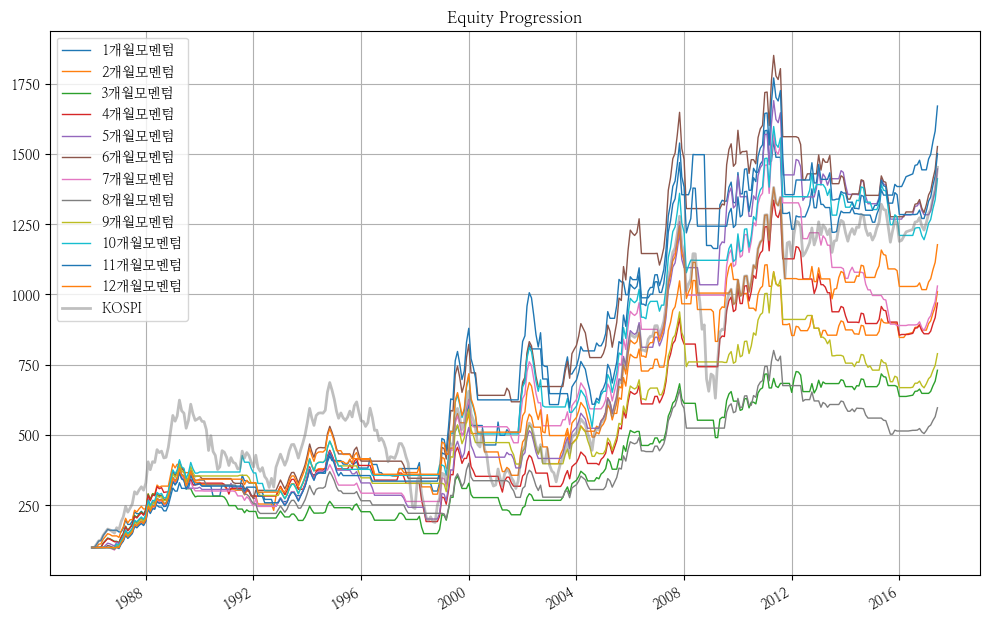

In [25]:
ax1 = rm_1_12.plot(figsize=(12, 8));
rm_kospi.plot(ax=ax1, lw=2, ls='-', color='gray', alpha=0.5, figsize=(12, 8));

plot_df()함수 사용(utils)

- legend 칼라와 순서를 맞춘다.

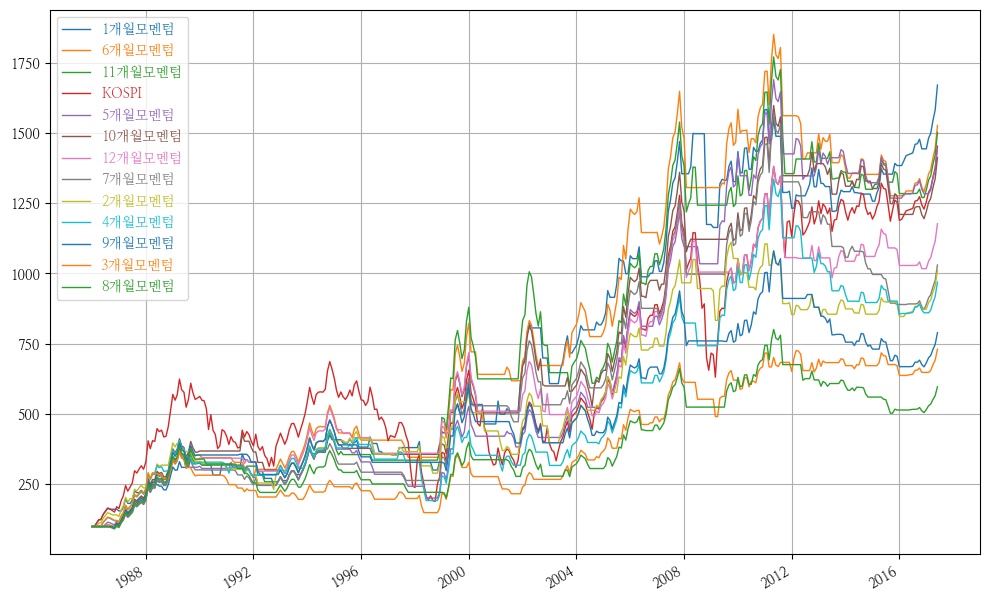

In [26]:
df = bt.merge(rm_1_12.prices, rm_kospi.prices)
plot_df(df, logy=False)

In [27]:
# legend의 순서가 그래프의 마지막값 순서
rm_1_12.prices.tail(1).T.sort_values(by='2017-06-01', ascending=False)

,2017-06-01
1개월모멘텀,1670.259
6개월모멘텀,1526.231
11개월모멘텀,1501.393
5개월모멘텀,1446.676
10개월모멘텀,1412.269
12개월모멘텀,1177.185
7개월모멘텀,1030.140
2개월모멘텀,1010.507
4개월모멘텀,969.458
9개월모멘텀,789.542


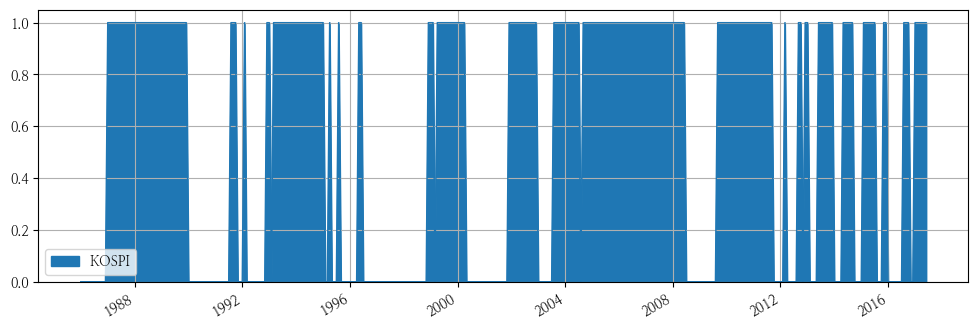

In [28]:
rm_1_12.get_security_weights(11).plot.area(figsize=(12,4));

In [29]:
rm369 = bt.run(test_m_mom[1], test_m_mom[3], test_m_mom[6],
               test_m_mom[9], test_m_mom[12], bt_kospi)

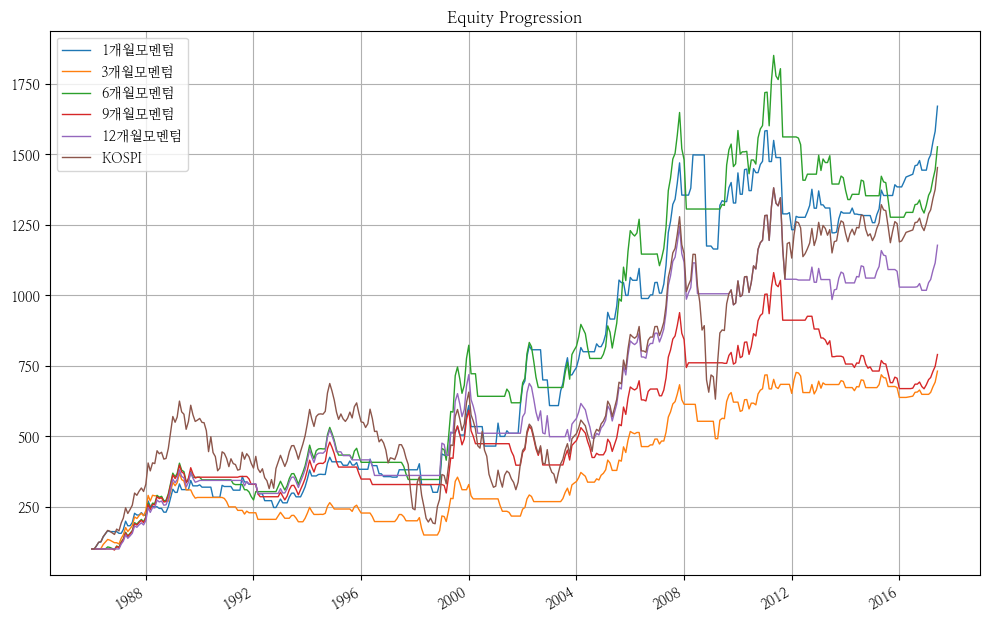

In [31]:
rm369.plot(figsize=(12,8));

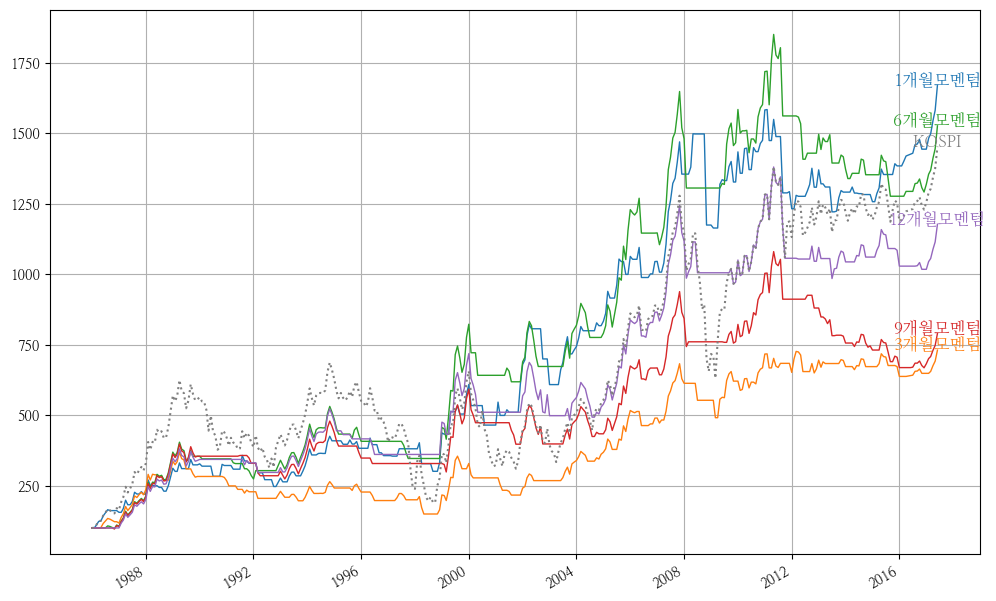

In [33]:
r = rm369.prices.rebase()
ax = r.iloc[:, 0:-1].plot(legend=False);# kospi제외
r.iloc[:,-1].plot(ax=ax, color='gray', lw=1.5, ls=':', label='KOSPI', figsize=(12,8));
# leg = ax.legend()
# print(dir(list(ax.get_lines())[0]))

# for l in list(ax.get_lines()):
#     print(l.get_label(), l.get_color())

for i, line in enumerate(list(ax.get_lines())):
    ax.text(r.index[-1], r.iloc[-1,i], line.get_label(), size=12, color=line.get_color(), ha='center');

# style = dict(size=12, color='black', ha='center')
# ax.text(r.index[-1], r.iloc[-1,0], '1개월모멘텀 ', **style)
# ax.text(r.index[-1], r.iloc[-1,1], '3개월모멘텀 ', **style)
# ax.text(r.index[-1], r.iloc[-1,2], '6개월모멘텀 ', **style)
# ax.text(r.index[-1], r.iloc[-1,3], '9개월모멘텀 ', **style)
# ax.text(r.index[-1], r.iloc[-1,4], '12개월모멘텀 ', **style)
# ax.text(r.index[-1], r.iloc[-1,5], 'KOSPI ', **style)
plt.show();

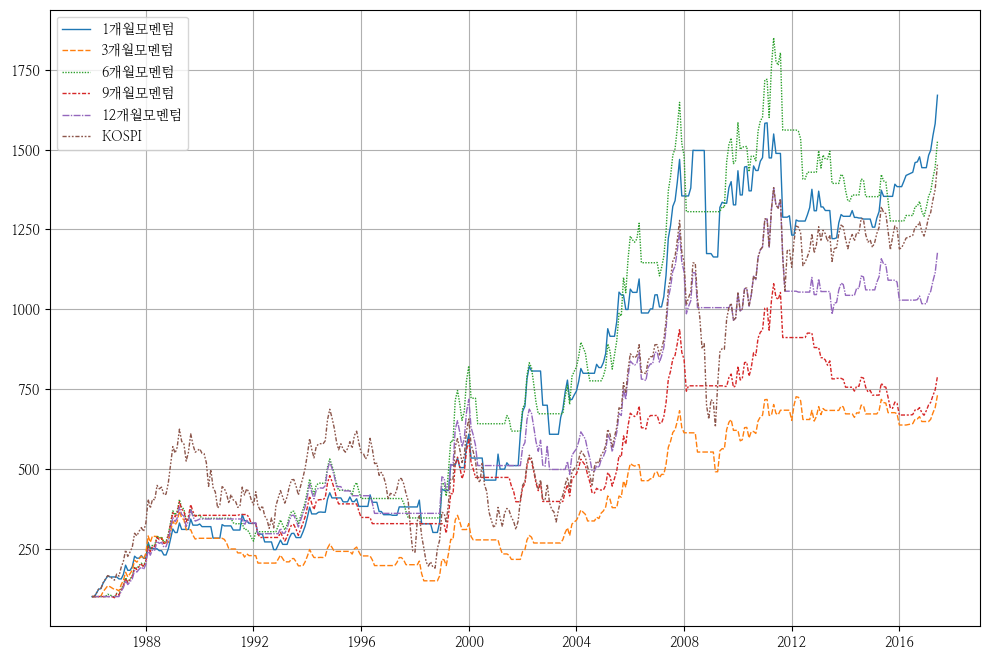

In [34]:
# %% seaborn으로 그리면
import seaborn as sns
plt.figure(figsize=(12,8))
sns.lineplot(data=r);

## bt의 Algo 클래스를 작성하여 동일 전략을 백테스팅 해보자.

In [35]:
class Signal(bt.Algo):
    """

    Mostly copied from StatTotalReturn

    Sets temp['Signal'] with total returns over a given period.

    Sets the 'Signal' based on the total return of each
    over a given lookback period.

    Args:
        * lookback (DateOffset): lookback period.
        * lag (DateOffset): Lag interval. Total return is calculated in
            the inteval [now - lookback - lag, now - lag]

    Sets:
        * stat

    Requires:
        * selected

    """


    def __init__(self, lookback=pd.DateOffset(months=3), lag=pd.DateOffset(days=0)):
        super(Signal, self).__init__()
        self.lookback = lookback
        self.lag = lag

    def __call__(self, target):
#         print(f"\n====== {target.now}, {self.lookback}")
        selected = target.temp['selected']
        t0 = target.now - self.lag

        if target.universe[selected].index[0] > (t0 - self.lookback): # !!!
            return False

        prc = target.universe[selected].loc[t0 - self.lookback:t0]
        # print(target.now, t0 , t0 - self.lookback, '\n', prc)

        trend = prc.iloc[-1]/prc.iloc[0] - 1
        signal = trend > 0.

        target.temp['Signal'] = signal.astype(float)

        return True



class WeighFromSignal(bt.Algo):

    """
    Sets temp['weights'] from the signal.
    Sets:
        * weights

    Requires:
        * selected

    """

    def __init__(self):
        super(WeighFromSignal, self).__init__()

    def __call__(self, target):
        selected = target.temp['selected']
        if target.temp['Signal'] is None:
            raise(Exception('No Signal!'))

        target.temp['weights'] = target.temp['Signal']
        return True

In [36]:
def abs_momentum_month(data, tickers = ['KOSPI'], n=1, name="1개월모멘텀"):
    if n == 12: # months=12로 하면 이상하게 months=12, years=1이되어 24개월의 모멘텀을 구한다.
        offset = pd.DateOffset(years=1)
    else:
        offset = pd.DateOffset(months=n)

    s = bt.Strategy(
        name,
        [
            bt.algos.RunMonthly(run_on_first_date=True, run_on_last_date=True),
            bt.algos.SelectThese(tickers),
            Signal(lookback=offset, lag=pd.DateOffset(days=1)),
            WeighFromSignal(),
            bt.algos.PrintInfo("{now} {temp}"),
            bt.algos.Rebalance()
        ]
    )

    t = bt.Backtest(s, data)
    return t

In [37]:
data = kospi['1986-1':'2017-6'].copy() # 일간 데이터
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8380 entries, 1986-01-04 to 2017-06-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   KOSPI   8380 non-null   float64
dtypes: float64(1)
memory usage: 130.9 KB


In [38]:
bt_1 = abs_momentum_month(data, ['KOSPI'], 1, name='1개월')
r_1 = bt.run(bt_1)

1986-03-03 00:00:00 {'selected': ['KOSPI'], 'Signal': KOSPI   1.000
dtype: float64, 'weights': KOSPI   1.000
dtype: float64}
1986-04-01 00:00:00 {'selected': ['KOSPI'], 'Signal': KOSPI   1.000
dtype: float64, 'weights': KOSPI   1.000
dtype: float64}
1986-05-01 00:00:00 {'selected': ['KOSPI'], 'Signal': KOSPI   1.000
dtype: float64, 'weights': KOSPI   1.000
dtype: float64}
1986-06-02 00:00:00 {'selected': ['KOSPI'], 'Signal': KOSPI   1.000
dtype: float64, 'weights': KOSPI   1.000
dtype: float64}
1986-07-01 00:00:00 {'selected': ['KOSPI'], 'Signal': KOSPI   1.000
dtype: float64, 'weights': KOSPI   1.000
dtype: float64}
1986-08-01 00:00:00 {'selected': ['KOSPI'], 'Signal': KOSPI   1.000
dtype: float64, 'weights': KOSPI   1.000
dtype: float64}
1986-09-01 00:00:00 {'selected': ['KOSPI'], 'Signal': KOSPI   0.000
dtype: float64, 'weights': KOSPI   0.000
dtype: float64}
1986-10-02 00:00:00 {'selected': ['KOSPI'], 'Signal': KOSPI   0.000
dtype: float64, 'weights': KOSPI   0.000
dtype: float64}


In [39]:
r_1.display()

Stat                 1개월
-------------------  ----------
Start                1986-01-03
End                  2017-06-30
Risk-free rate       0.00%

Total Return         854.25%
Daily Sharpe         0.50
Daily Sortino        0.77
CAGR                 7.43%
Max Drawdown         -47.67%
Calmar Ratio         0.16

MTD                  1.89%
3m                   10.49%
6m                   18.04%
YTD                  18.04%
1Y                   23.10%
3Y (ann.)            11.06%
5Y (ann.)            6.02%
10Y (ann.)           -0.69%
Since Incep. (ann.)  7.43%

Daily Sharpe         0.50
Daily Sortino        0.77
Daily Mean (ann.)    8.08%
Daily Vol (ann.)     16.07%
Daily Skew           0.00
Daily Kurt           13.29
Best Day             11.95%
Worst Day            -10.57%

Monthly Sharpe       0.49
Monthly Sortino      0.92
Monthly Mean (ann.)  8.79%
Monthly Vol (ann.)   18.11%
Monthly Skew         0.98
Monthly Kurt         7.01
Best Month           32.00%
Worst Month          -22.69%

Ye

In [40]:
def abs_momentum_month(data, tickers = ['KOSPI'], n=1, name="1개월모멘텀"):
    if n == 12: # months=12로 하면 이상하게 months=12, years=1이되어 24개월의 모멘텀을 구한다.
        offset = pd.DateOffset(years=1)
    else:
        offset = pd.DateOffset(months=n)

    s = bt.Strategy(
        name,
        [
            bt.algos.RunMonthly(run_on_first_date=True, run_on_last_date=True),
            bt.algos.SelectThese(tickers),
            Signal(lookback=offset, lag=pd.DateOffset(days=1)),
            WeighFromSignal(),
#             bt.algos.PrintInfo("{now} {temp}"),
            bt.algos.Rebalance()
        ]
    )

    t = bt.Backtest(s, data)
    return t

test_mom = dict()
for i in range(1, 13):
    test_mom[i] = abs_momentum_month(data, ['KOSPI'], i, name=str(i)+"개월모멘텀")
